# Lab 11b: Minimum-Variance Portfolio Allocation Problems
[Markowitz portfolio allocation](https://en.wikipedia.org/wiki/Markowitz_model) identifies the weights $\omega$'s for assets in a portfolio such that the portfolio variance (risk) is minimized for a specified rate of portfolio return (reward). The Markowitz allocation problem for a portfolio $\mathcal{P}$ composed of only risky assets is given by:

\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}\omega_{i}\omega_{j}
\text{cov}\left(r_{i},r_{j}\right) \\
\text{subject to}~\mathbb{E}(r_{\mathcal{P}})& = & \sum_{i\in\mathcal{P}}\omega_{i}\cdot\mathbb{E}(r_{i})\geq{R^{*}}\\
\sum_{i\in\mathcal{P}}\omega_{i} & = & 1\\
\text{and}~\omega_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}

The term $\omega_{i}\geq{0}$ denotes the fraction of asset $i$ in the portfolio $\mathcal{P}$, $R^{*}$ is the minimal required return for $\mathcal{P}$, $\sigma_{\mathcal{P}}$ denotes the portfolio variance, $r_{i}$ denotes the return for asset $i$ and $\text{cov}\left(r_{i},r_{j}\right)$ denotes [covariance](https://en.wikipedia.org/wiki/Covariance) between the return of asset $i$ and $j$ in the portfolio. 

### Learning objectives
In `Lab 11b` we'll compute the [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier) for a portfolio of risky assets, where the expected return and the covariance of the returns are calculated from a historical dataset. 

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `10-31-2023`.
* __Task 1__: Next, we'll compute the expected returns and the covariance arrays from the historical dataset
* __Task 2__: We'll compute the efficient frontier by solving the optimization problem described above: minimize the risk for a specified minimum reward value.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Labs-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
    Updating `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
  [6c6a2e73] ↑ Scratch v1.2.0 ⇒ v1.2.1


### Types
The `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, which encodes data required to compute the efficient frontier for a collection of $N$ risky assets only, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix, with entries $cov(r_{i},r_{j})$
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values with elements $\mathbb{E}(r_{i})$
* `bounds::Array{Float64,2}` is an $N\times{2}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the desired return
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses

The `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem`, which encodes data required to compute the optimal allocation for a portfolio containing $N$ risky assets and a single risk-free asset, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix, with entries $cov(r_{i},r_{j})$
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values, with elements $\mathbb{E}(r_{i})$
* `bounds::Array{Float64,2}` is an $N\times{2}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the desired return
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses
* `risk_free_rate::Float64` is the risk-free rate of return, e.g., the rate of return on a [10-year US Treasury Note](https://www.cnbc.com/bonds/)

### Functions
* The `MyPortfolioDataSet()` function loads the risky asset price dataset, and returns it as a [DataFrame.jl](https://dataframes.juliadata.org/stable/) instance. 
* The ` MyFirmMappingDataSet()` function load the firm mapping, and returns it as a [DataFrame.jl](https://dataframes.juliadata.org/stable/) instance.
* The `build(...)` is a factory method that takes the type of object that you wish to construct, and the parameters required to construct the object, e.g., the fields of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` or `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` types.
* The `solve(...)` method takes a `problem` type, e.g., an instance of `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` and returns the solution to the problem as a [Julia Dictionary](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) instance.

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `10-31-2023`, along with data for a few exchange traded funds and volatility products during that time. 

We load the `orignal_dataset` by calling the `MyPortfolioDataSet()` function:

In [2]:
original_dataset = MyPortfolioDataSet() |> x-> x["dataset"]

Dict{String, DataFrame} with 514 entries:
  "TPR"  => 1467×8 DataFrame…
  "EMR"  => 1467×8 DataFrame…
  "CTAS" => 1467×8 DataFrame…
  "HSIC" => 1467×8 DataFrame…
  "KIM"  => 1467×8 DataFrame…
  "PLD"  => 1467×8 DataFrame…
  "IEX"  => 1467×8 DataFrame…
  "KSU"  => 994×8 DataFrame…
  "BAC"  => 1467×8 DataFrame…
  "CBOE" => 1467×8 DataFrame…
  "EXR"  => 1467×8 DataFrame…
  "NCLH" => 1467×8 DataFrame…
  "CVS"  => 1467×8 DataFrame…
  "DRI"  => 1467×8 DataFrame…
  "DTE"  => 1467×8 DataFrame…
  "ZION" => 1467×8 DataFrame…
  "AVY"  => 1467×8 DataFrame…
  "EW"   => 1467×8 DataFrame…
  "EA"   => 1467×8 DataFrame…
  "NWSA" => 1467×8 DataFrame…
  "BBWI" => 566×8 DataFrame…
  "CAG"  => 1467×8 DataFrame…
  "GPC"  => 1467×8 DataFrame…
  "FCX"  => 1467×8 DataFrame…
  "GILD" => 1467×8 DataFrame…
  ⋮      => ⋮

In [3]:
original_dataset["VXX"]

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,1.46279e6,423.262,425.76,422.08,426.08,420.16,2018-01-03T05:00:00,94893
2,1.3692e6,419.843,417.92,421.12,422.56,416.16,2018-01-04T05:00:00,89927
3,1.35885e6,421.138,420.16,420.48,423.68,419.68,2018-01-05T05:00:00,79737
4,1.14406e6,416.586,419.84,415.68,421.92,412.16,2018-01-08T05:00:00,68794
5,1.69741e6,416.216,413.12,420.48,420.64,411.68,2018-01-09T05:00:00,93532
6,2.21174e6,419.73,424.32,415.84,430.56,413.44,2018-01-10T05:00:00,134122
7,1.52584e6,412.202,411.84,413.44,414.88,409.44,2018-01-11T05:00:00,82651
8,1.70059e6,412.586,411.68,413.6,415.36,410.32,2018-01-12T05:00:00,98223
9,4.04765e6,429.837,416.32,439.04,443.68,415.36,2018-01-16T05:00:00,271275


### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of tradition days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [4]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [5]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 459 entries:
  "NI"   => 1467×8 DataFrame…
  "EMR"  => 1467×8 DataFrame…
  "CTAS" => 1467×8 DataFrame…
  "HSIC" => 1467×8 DataFrame…
  "KIM"  => 1467×8 DataFrame…
  "PLD"  => 1467×8 DataFrame…
  "IEX"  => 1467×8 DataFrame…
  "BAC"  => 1467×8 DataFrame…
  "CBOE" => 1467×8 DataFrame…
  "EXR"  => 1467×8 DataFrame…
  "NCLH" => 1467×8 DataFrame…
  "CVS"  => 1467×8 DataFrame…
  "DRI"  => 1467×8 DataFrame…
  "DTE"  => 1467×8 DataFrame…
  "ZION" => 1467×8 DataFrame…
  "AVY"  => 1467×8 DataFrame…
  "EW"   => 1467×8 DataFrame…
  "EA"   => 1467×8 DataFrame…
  "NWSA" => 1467×8 DataFrame…
  "CAG"  => 1467×8 DataFrame…
  "GPC"  => 1467×8 DataFrame…
  "FCX"  => 1467×8 DataFrame…
  "GILD" => 1467×8 DataFrame…
  "UNP"  => 1467×8 DataFrame…
  "CDW"  => 1467×8 DataFrame…
  ⋮      => ⋮

Lastly, let's get a list of firms that we have in cleaned up `dataset`, and save it ib the `all_tickers` array

In [6]:
all_tickers = keys(dataset) |> collect |> sort;

### Compute the covariance and expected yield for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 459` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [7]:
all_firms_return_matrix = log_return_matrix(dataset, all_tickers, Δt = (1.0/252.0))

1466×459 Matrix{Float64}:
  0.374988    1.92928      7.02769   …   5.80159      1.79882    2.05452
  2.18987    -0.618139     4.02037       4.00668     -0.711936   2.9759
  0.936321   -1.91617     -0.803754      2.89928     -0.355978   2.46921
  6.20162     1.51203     -1.87102       6.60558      5.1484     3.41373
 -3.47638     4.92131     -0.267677      1.81502      3.3669    -4.87013
 -0.32572    10.2817       2.80668   …  10.7317       2.24034    2.48203
  3.30669     9.96413      7.37109       5.85955      2.39702    3.15105
 -0.169697    1.28539     -1.51874       2.72067     -1.55483    1.107
  1.69849    -0.255863     1.95851       0.439849    -0.102035   2.84631
  0.2133      0.137904    -0.483602     -0.160856    -0.505564  -1.09091
  3.01852    -0.976896     3.86638   …  -0.0478694    2.28925    0.992827
  0.913209   -0.686871     1.00017       0.282196     1.8914     1.48424
  1.10596     0.0969966    1.8855        2.45996      1.40743    1.8296
  ⋮                         

Next, we estimate the expected return for each firm from the `all_firms_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ in the variable $\mu$:

In [8]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

Finally, we estimate the annualized `covariance_matrix` from the `all_firms_return_matrix` using the `cov(...)` function, exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [9]:
Σ = cov(all_firms_return_matrix) |> x-> x*(1/252) # annualized, historical volatility

459×459 Matrix{Float64}:
 0.064826   0.0409281  0.0261112  …  0.0437684  0.0333458  0.0361722
 0.0409281  0.28844    0.0559517     0.0695894  0.0981789  0.0384516
 0.0261112  0.0559517  0.12152       0.0371791  0.0473042  0.0284067
 0.0331378  0.0455132  0.0241594     0.0465963  0.0269359  0.0343761
 0.0203118  0.0208757  0.0204009     0.0180597  0.0218998  0.0231445
 0.0321251  0.023003   0.0183003  …  0.0305132  0.0201168  0.0306816
 0.0350969  0.0483224  0.0324395     0.045519   0.0394397  0.0360119
 0.0398864  0.0368055  0.0256186     0.0540521  0.0247386  0.0393271
 0.0386518  0.0643283  0.0287233     0.05471    0.041364   0.0336763
 0.0210783  0.0476765  0.0257671     0.0279022  0.0448728  0.0183184
 0.0289289  0.0481221  0.0297819  …  0.0375749  0.036449   0.0309174
 0.0489615  0.0657579  0.0346923     0.0655548  0.0401993  0.0438171
 0.0170419  0.0187905  0.0188258     0.0173288  0.0185786  0.0210492
 ⋮                                ⋱                        
 0.0227522  0.0556

## Task 1: Build the log return array and covariance matrix
Before we compute the efficient frontier, we must decide which stocks to include in the risky portfolio. One strategy is to pick stocks that have small or even negative covariance. Let's explore this idea. 

* Specify a collection of `ticker symbols`, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers` array. We'll  put the indexes of your tickers in the `my_list_of_firm_ids` array:

In [10]:
my_list_of_tickers = ["AAPL", "INTC", "MSFT", "MU", "AMD", "GS", "BAC", "WFC", "C", "F"];
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end

Now that you have selected the firms in your risky portfolio, we'll compute for you the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, we'll construct the $\hat{\mu}$ vector:

In [11]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
end
# ---------------------------------------------------------------------- #

In [12]:
μ̂

10-element Vector{Float64}:
  0.23510458725899908
 -0.03662250341304818
  0.23425752960746085
  0.06841598016453106
  0.3634941098143528
  0.03031451924245087
 -0.02245480568170263
 -0.07579506321156709
 -0.10978328619082807
 -0.045158390772303277

and then we'll compute the firm-specific covariance $\hat{\Sigma}$ matrix:

In [13]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

In [14]:
 Σ̂

10×10 Matrix{Float64}:
 0.0704696  0.0388217  0.0437848  …  0.0268379  0.0359266  0.0376837
 0.0388217  0.0970712  0.0361836     0.0333337  0.0408035  0.03831
 0.0437848  0.0361836  0.0567064     0.0242269  0.0312063  0.0309865
 0.0512598  0.0672573  0.0452065     0.0510921  0.0625337  0.0666329
 0.0605189  0.0535516  0.0585346     0.036667   0.0507444  0.0578215
 0.0326635  0.0357472  0.0289054  …  0.0636951  0.0738309  0.0604013
 0.0308444  0.0356729  0.0276028     0.0785802  0.0856406  0.065825
 0.0268379  0.0333337  0.0242269     0.0984358  0.0817752  0.065447
 0.0359266  0.0408035  0.0312063     0.0817752  0.107968   0.0764654
 0.0376837  0.03831    0.0309865     0.065447   0.0764654  0.143876

## Task 2: Compute the efficient frontier for your collection of stocks
Create an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, and store this in the `problem_risk` variable using the `build(...)` method. You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the `build(...)` method. 

Let's setup the bounds, and some other constants:

In [15]:
number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 40;

and the build an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, using the `build(...)` method:

In [16]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, we create an array with the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable:

In [17]:
minimum_desired_reward_array = range(risk_free_rate, stop = 0.5, length = number_of_points) |> collect;

Finally, we iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward
* We then pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `frontier` dictionary.

In [18]:
efficient_frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk.R = minimum_desired_reward_array[i];
    
    # compute -
    solution = solve(problem_risk)

    # check: did this converge?
    status_flag = solution["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution["objective_value"]);
        value = solution["reward"];
        efficient_frontier[key] = value;
    end
end
efficient_frontier

Dict{Float64, Float64} with 28 entries:
  0.207492 => 0.124242
  0.345041 => 0.315385
  0.219786 => 0.211538
  0.207492 => 0.124242
  0.207492 => 0.124242
  0.371536 => 0.326923
  0.207492 => 0.124242
  0.258467 => 0.269231
  0.399243 => 0.338462
  0.213868 => 0.188462
  0.244268 => 0.257692
  0.216497 => 0.2
  0.296968 => 0.292308
  0.234304 => 0.246154
  0.207492 => 0.124242
  0.207492 => 0.124242
  0.207993 => 0.142308
  0.276248 => 0.280769
  0.427925 => 0.35
  0.207492 => 0.124242
  0.208849 => 0.153846
  0.207556 => 0.130769
  0.2238   => 0.223077
  0.211791 => 0.176923
  0.320058 => 0.303846
  ⋮        => ⋮

### Visualize the Efficient Frontier

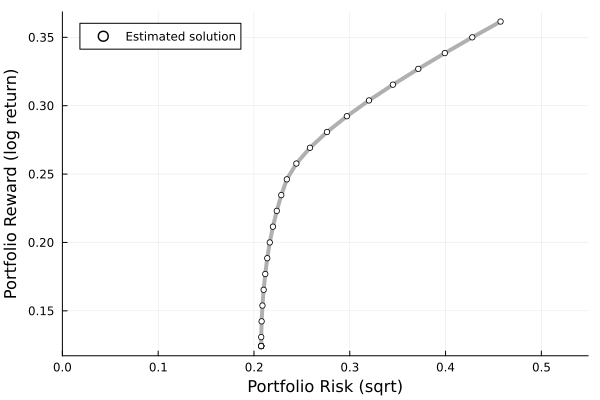

In [19]:
plot(efficient_frontier, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Reward (log return)", fontsize=18, label="", c=:gray69, 
    xlim=(0.0, 1.2*maximum(efficient_frontier).first))
scatter!(efficient_frontier, label="Estimated solution", c=:white, mec=:black, ms=3)

### Let's look at some portfolios

In [20]:
min_var_reward = values(efficient_frontier) |> minimum

0.12424166840153272

In [31]:
# problem.R = min_var_reward;
problem_risk.R = 0.35;
#problem_risk.R = risk_free_rate
solution = solve(problem_risk)

Dict{String, Any} with 4 entries:
  "argmax"          => [0.012317, -5.61874e-9, 0.0921779, -4.01049e-9, 0.895505…
  "reward"          => 0.35
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.18312

In [32]:
let
    ω = solution["argmax"];
    table_df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        ωᵢ = ω[i];
        row_data = (
            ticker = ticker,
            ω = round(ωᵢ, digits=4)
        );
        push!(table_df,row_data)
    end
    
    # compute the total -
    total = table_df[:,:ω] |> sum
    last_row = (
        ticker = "total",
        ω = total
    )
    push!(table_df,last_row)
    table_df
end

Row,ticker,ω
,String,Float64
1,AAPL,0.0123
2,INTC,-0.0
3,MSFT,0.0922
4,MU,-0.0
5,AMD,0.8955
6,GS,-0.0
7,BAC,-0.0
8,WFC,-0.0
9,C,-0.0


### Task 3: Compute Optimal allocation with risky and risk-free assets
The Minimum-Variance (Markowitz) portfolio allocation problem for a portfolio composed of risk-free and risky assets $\mathcal{P}$ 
minimizes the variance of the portfolio $\sigma_{\mathcal{P}}^2$ 
subject to a minimal required return and non-negativity constraints: 

\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}\omega_{i}\omega_{j}
\text{cov}\left(r_{i},r_{j}\right) \\
\text{subject to}~\mathbb{E}(r_{\mathcal{P}})& = & \left(\omega_{f}r_{f}+\sum_{i\in\mathcal{P}}\omega_{i}\cdot\mathbb{E}(r_{i})\right)\geq{R^{*}}\\
\omega_{f}+\sum_{i\in\mathcal{P}}\omega_{i} & = & 1 \\
\text{and}~\omega_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}

The terms $\omega_{i}\geq{0}$ denote the fraction of risky asset $i\in\mathcal{P}$, 
the quantity $\omega_{f}$ denotes the fraction of risk-free assets in the portfolio, 
$r_{f}$ denotes the risk free rate or return, and $R^{*}$ is the minimum required rate of return 
for overall portfolio $\mathcal{P}$.

#### Implementation
Let's create an instance of the `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` type, and store this in the `problem_risk_free` variable, using the `build(...)` method. We pass the covariance array estimated from data, and the expected return value, along with bounds, an initial guess and the risk free rate to the `build(...)` method:

In [23]:
problem_risk_free = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = wₒ,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level, in the presence of a risk-free asset, using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk_free` variable with the minimum desired reward
* We then pass the updated `problem_risk_free` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution_risk_free` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `capital_allocation_line` dictionary.

In [24]:
capital_allocation_line = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_free.R = minimum_desired_reward_array[i];
    
    # compute -
    solution_risk_free = solve(problem_risk_free)

    # check: did this converge?
    status_flag = solution_risk_free["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution_risk_free["objective_value"]);
        value = solution_risk_free["reward"];
        capital_allocation_line[key] = value;
    end
end
capital_allocation_line;

### Visualize the capital allocation line

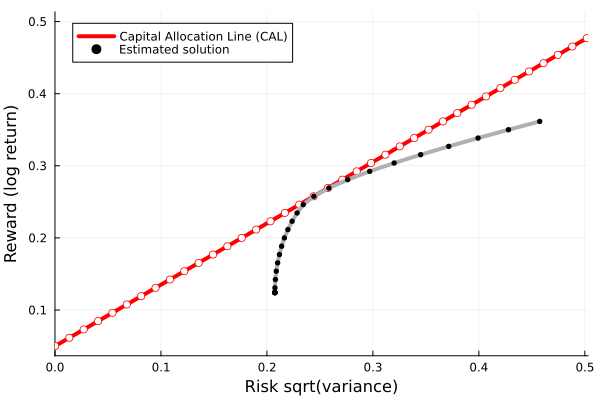

In [25]:
plot(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (annualized log growth)", fontsize=18, c=:red, 
    xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
scatter!(capital_allocation_line, label="", msc=:red, mc=:white)
plot!(efficient_frontier, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (log return)", fontsize=18, label="", c=:gray69, 
    xlim=(0.0, 1.1*maximum(efficient_frontier).first))
scatter!(efficient_frontier, label="Estimated solution", c=:black, ms=3)

### Where is the tangent portfolio $\mathcal{T}$?
The tangent portfolio is the point on the capital allocation line where the fraction of assets invested in the pool of risky assets is `1`, i.e., all of our investment budget is invested in equities. Let's estimate the expected return of the tangent portfolio $\mathcal{T}$ by trial and error:

In [26]:
problem_risk_free.R = 0.2615
allocation_sum_constraint = solve(problem_risk_free) |> x-> x["argmax"] |> x-> sum(x);
println("fraction in risk-free assets: $(1-allocation_sum_constraint), fraction in risky assets: $(allocation_sum_constraint)")

fraction in risk-free assets: 9.201085528387498e-5, fraction in risky assets: 0.9999079891447161


Let's solve the investment problem at the tangent portfolio:

In [27]:
tangent_portfolio_solution = solve(problem_risk_free)

Dict{String, Any} with 4 entries:
  "argmax"          => [0.25371, 1.14144e-8, 0.536934, 1.87279e-8, 0.209264, 2.…
  "reward"          => 0.2615
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.0617606

What's in the tangent portfolio?

In [28]:
let
    ω = tangent_portfolio_solution["argmax"];
    table_df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        ωᵢ = ω[i];
        row_data = (
            ticker = ticker,
            ω = round(ωᵢ, digits=4)
        );
        push!(table_df,row_data)
    end
    
    # compute the total -
    total = table_df[:,:ω] |> sum
    last_row = (
        ticker = "total",
        ω = total
    )
    push!(table_df,last_row)
    table_df
end

Row,ticker,ω
,String,Float64
1,AAPL,0.2537
2,INTC,0.0
3,MSFT,0.5369
4,MU,0.0
5,AMD,0.2093
6,GS,0.0
7,BAC,0.0
8,WFC,0.0
9,C,0.0


### Compute my $\theta^{\star}$ value as a function of the risk-aversion parameter $A$
An investor becomes more `risk-averse`, less tolerant of risk as the risk-aversion parameter $A$ increases. Conversely, as the risk-aversion parameter $A$ decreases, an investor is less `risk-averse`, i.e., they are more willing to tolerate uncertainty in the return of their portfolio.

Let's set some values for the risk-aversion parameter $A$, and look at what this does to our choices:

In [40]:
A = 8;

In [42]:
variance = tangent_portfolio_solution["objective_value"]
θ̂ = (problem_risk_free.R - risk_free_rate)/(A*variance);
risk_value = θ̂*sqrt(variance);
reward_value = θ̂*(problem_risk_free.R)+(1-θ̂)*problem_risk_free.risk_free_rate;
println("θ̂ = $(θ̂), reward = $(reward_value), risk (σ) = $(risk_value)")

θ̂ = 0.42806439861626006, reward = 0.14053562030733902, risk (σ) = 0.10638116627682448


## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.